In [1]:
import numpy as np
import os
from pathlib import Path
from scipy.io import wavfile
import matplotlib.pyplot as plt
import seaborn as sn
import random
import glob
from sklearn.cluster import KMeans

In [2]:
#function to generate spectrogram
def gen_spectrogram(X):
    
    num_of_samples=int((X.shape[0]-400)/160)+1
    data=[list(X[i*160:i*160+400]) for i in range(num_of_samples) ]
    data=np.array(data)
    W=np.hamming(400)
    temp=np.zeros((400,32)) #dim 32
    for i in range(400):
        for j in range(32):
               temp[i,j] = W[i]*np.exp((-2j*np.pi*i*j)/400).real
  
    X_all = np.log(np.abs(data@temp).T)
    return X_all

## Reading files and generating spectrogram

In [9]:
# reading all file names
dir1 = './speech_music_classification/train/music'
dir2 = './speech_music_classification/test'
dir3 = './speech_music_classification/train/speech'
 
tr_mu = Path(dir1).glob('*')
tr_music_l=[]
for i in tr_mu:
    tr_music_l.append(i)
test_tar=[]   
te = Path(dir2).glob('*')
test_l=[]
for i in te:
    test_l.append(i)
    if (str(i)[33]=='s'):
        test_tar.append(0)
    if (str(i)[33]=='m'):
        test_tar.append(1)
    
tr_sp = Path(dir3).glob('*')
tr_speech_l=[]
for i in tr_sp:
    tr_speech_l.append(i)
#test_l

In [10]:
#reading all files
music_train=[]
speech_train=[]
test_audio=[]

#assigning label 0 to music and 1 to speech
truth_lables_train=[]
for i in range(len(tr_music_l)):
    truth_lables_train.append(0)

for i in range(len(tr_speech_l)):
    truth_lables_train.append(1)
    
for i in range(len(tr_music_l)):
    music_train.append(wavfile.read(tr_music_l[i])[1])
    #print(music_train[i])
    speech_train.append(wavfile.read(tr_speech_l[i])[1])
    #print(speech_train[i][0])

for i in range(len(test_l)):
    test_audio.append(wavfile.read(test_l[i])[1])
    #print(test[i][0])

In [11]:
#generating spectrogram for all files
m_t_s=[]
s_t_s=[]
s_test=[]

for i in range(len(tr_music_l)):
    temp = gen_spectrogram(music_train[i])#getting spectrogram
    m_t_s+=[list(temp[:,j]) for j in range(temp.shape[1])]#appending all spectrograms 
    temp = gen_spectrogram(speech_train[i])
    s_t_s+=[list(temp[:,j]) for j in range(temp.shape[1])]
    
for i in range(len(test_l)):
    temp=gen_spectrogram(test_audio[i])
    s_test.append(temp.T)

m_t_s = np.array(m_t_s)
s_t_s = np.array(s_t_s)
s_test = np.array(s_test)

## Applying kmeans to discretize observations

In [12]:
#separating clusters on data index
def mod_clu(clu,data,k):
    li=[]
    for i in range(k):
        li.append([])
    for i in range(len(data)):
        li[clu[i]].append(i)
    return li

In [13]:
k=8 #clusters
kmeans_m = KMeans(n_clusters=k, random_state=0).fit(m_t_s)
clu_li_m = kmeans_m.labels_


In [14]:
kmeans_s = KMeans(n_clusters=8, random_state=0).fit(s_t_s)
clu_li_s = kmeans_s.labels_

In [15]:
s1=set(clu_li_s)
s2=set(clu_li_m)
print(s1)
print(s2)

{0, 1, 2, 3, 4, 5, 6, 7}
{0, 1, 2, 3, 4, 5, 6, 7}


In [16]:
cluster_list_music = mod_clu(clu_li_m,m_t_s,k)
cluster_list_speech = mod_clu(clu_li_s,s_t_s,k)

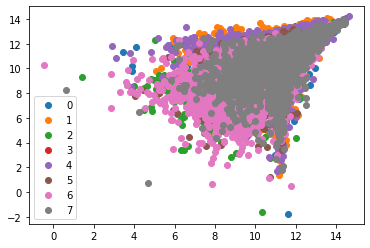

In [17]:
for i in range(8):
    plt.scatter([m_t_s[x][0] for x in cluster_list_music[i]],[m_t_s[x][1]for x in cluster_list_music[i]],label=i)
    plt.legend()
plt.show()

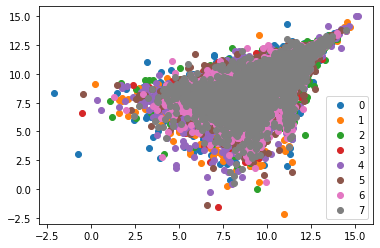

In [18]:
for i in range(8):
    plt.scatter([s_t_s[x][0] for x in cluster_list_music[i]],[s_t_s[x][1]for x in cluster_list_music[i]],label=i)
    plt.legend()
plt.show()

## Defining parameters for HMM

In [19]:
p=np.array([0.5,0.5,0],dtype=float)
A=np.array([[0.6,0.4,0],[0.3,0.5,0.2],[0,0.1,0.9]],dtype=float)
B=np.array([[0.25,0.25,0.25,0.25,0,0,0,0],[0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125],[0,0,0,0,0,0.5,0.5,0]],dtype=float)
pp=p
AA=A
BB=B

In [20]:
#subsampling data
chota_sub_s=[]
chota_sub_m=[]
ra=10
for i in range(int(np.floor(2998)/ra)):
    chota_sub_s.append(clu_li_s[i*ra])
    chota_sub_m.append(clu_li_m[i*ra])
print(len(chota_sub_m))

299


## a. Likelihood computation using forward variable

In [21]:
#t is the total time instances; o is the observation sequence; A, B, p characterize HMM
def forward(t,o,A,B,p):
    sol_sum=[]
    alpha=np.zeros([3,t],dtype=float)
    #initializing alpha
    #c_time=0
    for i in range(3):
        alpha[i,0]=p[i]*B[i,o[0]]
    #scaling
    temp1=np.sum(alpha[:,0])
#    alpha[:,0]=alpha[:,0]/temp1
    sol_sum.append(temp1)
    #c_time+=1
    for i in range(1,t):
        for j in range(3):
            for k in range(3):
                alpha[j,i]+=alpha[k,i-1]*A[k,j]*B[j,o[i]]
        temp1=np.sum(alpha[:,i])
#         alpha[:,i]=alpha[:,i]/temp1
        sol_sum.append(temp1)
    #print(alpha)   
    return np.sum(alpha[:,t-1]),sol_sum,alpha

### Likelihood of speech file

In [22]:
prob,li,al = forward(299,np.array(chota_sub_s),A,B,p)
#print("likelihood of speech file",abs(np.sum(np.log(li))))
print("likelihood of speech file",np.log(li[len(li)-1]))

likelihood of speech file -657.6785376012524


### Likelihood of music file

In [23]:
prob,li,al = forward(299,np.array(chota_sub_m),A,B,p)
#print("likelihood of music file",abs(np.sum(np.log(li))))
print("likelihood of music file",np.log(li[len(li)-1]))

likelihood of music file -680.2445771823473


### The speech file is more likely under the model

## b. Likelihood computation using backward variable

In [24]:
#t is the total time instances; o is the observation sequence; A, B, p characterize HMM
def backward(t,o,A,B,p):
    sol_sum=[]
    beta=np.zeros([3,t],dtype=float)
    #initializing beta
    #c_time=0
    beta[:,t-1]=1.0
    #scaling
    temp1=np.sum(beta[:,t-1])
#     beta[:,t-1]=beta[:,t-1]/temp1
    sol_sum.append(temp1)
    #c_time+=1
    for i in range(t-2,-1,-1):
        for j in range(3):
            for k in range(3):
                beta[j,i]+=beta[k,i+1]*A[k,j]*B[j,o[i+1]]
        temp1=np.sum(beta[:,i])
#         beta[:,i]=beta[:,i]/temp1
        sol_sum.append(temp1)
    #print(beta)   
    return np.sum(beta[:,0]),sol_sum,beta

### Likelihood of speech file

In [25]:
prob,li,al = backward(299,np.array(chota_sub_s),A,B,p)
#print("likelihood of speech file",abs(np.sum(np.log(li))))
print("likelihood of speech file",np.log(li[-1]))

likelihood of speech file -654.1218299202469


### Likelihood of music file

In [26]:
prob,li,al = backward(299,np.array(chota_sub_m),A,B,p)
#print("likelihood of speech file",abs(np.sum(np.log(li))))
print("likelihood of speech file",np.log(li[-1]))

likelihood of speech file -675.8625220924284


### The likelihood for same under backward and forward algo

## c. Using viterbi algo for decoding

In [27]:
#t is the total time instances; o is the observation sequence; A, B, p characterize HMM
def viterbi(t,o,A,B,p):
    delta=np.zeros([len(p),t])
    psy=np.zeros([len(p),t])
    #initialize
    for i in range(len(p)):
        delta[i,0]=p[i]*B[i,o[0]]
        psy[i,0]=0
    #scaling
    temp1=np.sum(delta[:,0])
    delta[:,0]=delta[:,0]/temp1
    
    #recursion
    for i in range(1,t):
        for j in range(len(p)):
            for k in range(len(p)):
                if k==0:
                    temp_d = delta[k,i-1]*A[k,j]
                    temp_p = k
                else:
                    val=delta[k,i-1]*A[k,j]
                    if(val>temp_d):
                        temp_d = val
                        temp_p = k
            delta[j,i] = temp_d * B[j,o[i]]
            psy[j,i] = temp_p
        temp1=np.sum(delta[:,i])
        delta[:,i]=delta[:,i]/temp1
    #termination
    p_star = np.max(delta[:,t-1])
    q_t_star = np.argmax(delta[:,t-1])
    #print(q_t_star)
    
    #backtracking
    
    sequence=np.zeros([t])
    sequence[t-1]=int(q_t_star)    
    for i in range(t-2,0,-1):
        #print(sequence[i+1])
        sequence[i]=psy[int(sequence[i+1]),i+1]
        
    return sequence

In [28]:
s1=viterbi(299,np.array(chota_sub_s),A,B,p)
s2=viterbi(299,np.array(chota_sub_m),A,B,p)

## Subsampling data for training

In [29]:
sub_s=[]
sub_m=[]
ra=400
for i in range(int(np.floor(len(clu_li_m)/ra))):
    sub_s.append(clu_li_s[i*ra])
    sub_m.append(clu_li_m[i*ra])


## Training model using Baum Welch

In [30]:
#t is time instances, n is number of states, al and be are from forward and backward algos
def gamma(al,be,t,n):
    ga=np.zeros([n,t])
    for i in range(t):
        temp = al[:,i]*be[:,i]
        temp2 = np.sum(temp)
        if (temp2==0):
            ga[:,i] = temp
        else:
            ga[:,i] = temp/temp2
    return ga

In [31]:
#t is time instances, n is number of states, al and be are from forward and backward algos, A,B, characterize HMM
def zeta(al,be,A,B,t,n,o):
    ze=np.zeros([n,n,t-1])
    for ti in range(t-1):
        de = 0
        for i in range(n):
            for j in range(n):
                de += al[i,ti]*A[i,j]*B[j,o[ti+1]]*be[j,ti+1]
        for i in range(n):
            for j in range(n):
                if de==0:
                    ze[i,j,ti] = (al[i,ti]*A[i,j]*B[j,o[ti+1]]*be[j,ti+1])
                else:
                    ze[i,j,ti] = (al[i,ti]*A[i,j]*B[j,o[ti+1]]*be[j,ti+1])/de
    return ze

In [63]:
def baumwelch(A,B,p,o,n):
    t = len(o)
    miter = 60
    p_new = p
    A_new = A
    B_new = B
    log_li=[]
    for i in range(miter):
        #print(i)
        prob, li, al = forward(t,o,A_new,B_new,p_new) 
        log_li.append(np.log(li[-1]))
        prob, li, be = backward(t,o,A_new,B_new,p_new)
        ga = gamma(al,be,t,n)
        #print(ga)
        ze = zeta(al,be,A_new,B_new,t,n,o)
        p_new = ga[:,0]
        for l in range(n):
            for j in range(n):
                num=0
                den=0
                for k in range(t-1):
                    num+=ze[l,j,k]
                den=np.sum(ga[l,:])
                #print(den)
                if den==0:
                    A_new[l,j] = 0
                else:
                    A_new[l,j] = num/den

        for l in range(n):
            for k in range(8):
                num=0
                den=0
                for j in range(t):
                    if (o[j]==k):
                        de = 1
                    else:
                        de = 0
                    num += de*ga[l,j]
                    den += ga[l,j]
                if den==0:
                    B_new[l,k] = 0
                else:
                    B_new[l,k] = num/den
                
    return A_new,B_new,p_new,log_li

In [64]:
p=np.array([0.5,0.5,0],dtype=float)
A=np.array([[0.6,0.4,0],[0.3,0.5,0.2],[0,0.1,0.9]],dtype=float)
B=np.array([[0.25,0.25,0.25,0.25,0,0,0,0],[0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125],[0,0,0,0,0,0.5,0.5,0]],dtype=float)
A_s,B_s,p_s,log_li = baumwelch(A,B,p,sub_s,3)


Text(0, 0.5, 'Log likelihood')

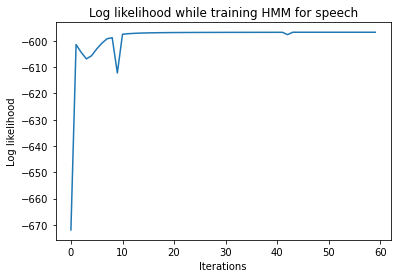

In [65]:
plt.title("Log likelihood while training HMM for speech")
plt.plot(range(len(log_li)),log_li)
plt.xlabel("Iterations")
plt.ylabel("Log likelihood")


In [72]:
p=np.array([0.5,0.5,0],dtype=float)
A=np.array([[0.6,0.4,0],[0.3,0.5,0.2],[0,0.1,0.9]],dtype=float)
B=np.array([[0.25,0.25,0.25,0.25,0,0,0,0],[0.125,0.125,0.125,0.125,0.125,0.125,0.125,0.125],[0,0,0,0,0,0.5,0.5,0]],dtype=float)
A_m,B_m,p_m,log_li_m = baumwelch(A,B,p,sub_m,3)

Text(0, 0.5, 'Log likelihood')

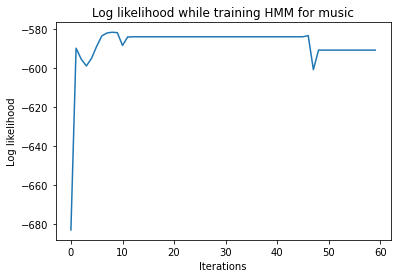

In [67]:
plt.title("Log likelihood while training HMM for music")
plt.plot(range(len(log_li_m)),log_li_m)
plt.xlabel("Iterations")
plt.ylabel("Log likelihood")

## Testing the trained HMMs

In [73]:
#speech 0 and music 1
predict=[]
count = 0
for i in range(48):
    #print(i)
    test = s_test[i]
    k=8 #clusters
    sequence_m = kmeans_m.predict(test)
    sequence_s = kmeans_s.predict(test)
    #print(sequence_m)
    s_s=[]
    s_m=[]
    ra=10
    for i in range(int(np.floor(len(sequence_m)/ra))):
        s_s.append(sequence_m[i*ra])
        s_m.append(sequence_s[i*ra])
    #print(s_s)
    pr_s,l_s,al_s = forward(len(s_s),s_s,A_s,B_s,p_s)
    pr_m,l_m,al_m = forward(len(s_m),s_m,A_m,B_m,p_m)
    log_m = np.log(l_m[-1])
    log_s = np.log(l_s[-1])
    if(log_m>=log_s):
        predict.append(1)
    else:
        predict.append(0)
    
for i in range(48):
    if predict[i] == test_tar[i]:
        count+=1


<ipython-input-73-91028d6efae4>:20: RuntimeWarning: divide by zero encountered in log
  log_m = np.log(l_m[-1])
<ipython-input-73-91028d6efae4>:20: RuntimeWarning: divide by zero encountered in log
  log_m = np.log(l_m[-1])
<ipython-input-73-91028d6efae4>:20: RuntimeWarning: divide by zero encountered in log
  log_m = np.log(l_m[-1])
<ipython-input-73-91028d6efae4>:20: RuntimeWarning: divide by zero encountered in log
  log_m = np.log(l_m[-1])


In [74]:
print("accuracy of the model is= ", count/48*100)  

accuracy of the model is=  70.83333333333334


In [70]:
predict

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0]